# 18-9. 프로젝트 : 다양한 OCR모델 비교하기

---

우리는 지금까지 Google OCR API, keras-ocr, Tesseract 이상 3가지의 OCR 기능을 간단히 활용하여 보았습니다.
오늘 다뤄본 위 3가지를 검증해 보는 프로젝트를 진행하겠습니다.   
여러분은 OCR 기능을 활용한 서비스를 빠르게 개발해야 하는 임무를 맡은 엔지니어가 되어, 어떤 모듈을 도입하면 좋을지 기술검증을 하는 역할을 맡게 되었다고 가정합니다.  

---

- OCR 접목 서비스: 메뉴판을 읽어주세요!  
  - 살면서 가장 중요한 것들 중 하나는 먹는게 아닐까요?
  - 영어 메뉴판을 받았을 때 검색하려 했으나 음식점 주인이 너무 악필이라면?
  - 해외 인생 맛집의 메뉴를 다시 찾고 싶을 때 이용할 수 있도록 OCR을 활용해봅시다. 

- 시작 전 주의 사항
  - keras-ocr은 한글 데이터셋으로 훈련이 되어있지 않아 한글을 인식하는데 낮은 효과를 보인다.
  - 각 모델들의 동등한 비교를 위해 영어 이미지를 기준으로 확인해본다.
  - 예시) 한글도 영어로 인식하기에 정확하게 분류되지 않는다.
  ![ex.png](/EXPLORATION_18/ex.png)


## Step 1. 검증용 데이터셋 준비

OCR을 적용해볼 책 표지들을 불러옵니다.

In [1]:
import os
import matplotlib.pyplot as plt
import cv2

import keras_ocr

import pytesseract
from PIL import Image
from pytesseract import Output

In [2]:
data_path = os.getenv('HOME')+ '/aiffel/ocr_python/image'
data_path

'/aiffel/aiffel/ocr_python/image'

In [3]:
# 입력 이미지 경로 
file_list = os.listdir(data_path)
file_path = [data_path+'/'+name for name in file_list]
file_path = sorted(file_path)
file_path

['/aiffel/aiffel/ocr_python/image/menu1.jpg',
 '/aiffel/aiffel/ocr_python/image/menu2.jpg',
 '/aiffel/aiffel/ocr_python/image/menu3.jpg',
 '/aiffel/aiffel/ocr_python/image/menu4.jpg']

## Step 2. Google OCR API, keras-ocr, Tesseract로 테스트 진행

### 1. Google OCR API

In [4]:
def detect_text(path):
    """Detects text in the file."""
    from google.cloud import vision
    import io
    client = vision.ImageAnnotatorClient()

    with io.open(path, 'rb') as image_file:
        content = image_file.read()
        
    image = vision.Image(content=content)

    response = client.text_detection(image=image)
    texts = response.text_annotations
    print('Texts:')

    for text in texts:
       print('\n"{}"'.format(text.description))

    vertices = (['({},{})'.format(vertex.x, vertex.y)
                 for vertex in text.bounding_poly.vertices])

    print('bounds: {}'.format(','.join(vertices)))

    if response.error.message:
        raise Exception(
            '{}\nFor more info on error messages, check: '
            'https://cloud.google.com/apis/design/errors'.format(
                response.error.message))

In [5]:
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] =  os.getenv('HOME')+'/aiffel/ocr_python/spry-scope-326515-82b7e7a9ea09.json'

In [6]:
# 위에서 정의한 OCR API 이용 함수를 호출해 봅시다.
for path in file_path:
    detect_text(path)
    print('-------------------------------------------------------------------------')

Texts:

"WITH SALT
RUM
SHAKE STRAIN
35ml TEQUILA: into
20 ml COINTREAU
WITH ICE
WITH LIME
"

"WITH"

"SALT"

"RUM"

"SHAKE"

"STRAIN"

"35ml"

"TEQUILA:"

"into"

"20"

"ml"

"COINTREAU"

"WITH"

"ICE"

"WITH"

"LIME"
bounds: (554,465),(580,461),(582,474),(556,478)
-------------------------------------------------------------------------
Texts:

"YY MAINDISHES
Name of dish
10.00
La pen
Name of dish
10.00
Lo p
Name of dish
10.00
La pan
MENU
BEVERAGES
Name of drink
10.00
Lons
Name of drink
La pn dder
Amazing dishes from chef
10.00
Name of drink
10.00
La
DESSERTS
Name of piece
Lo peen der
10.00
Name of piece
Lann panider
10.00
Name of piece
10.00
Lo pn dr
wwwsheaame.on
"

"YY"

"MAINDISHES"

"Name"

"of"

"dish"

"10.00"

"La"

"pen"

"Name"

"of"

"dish"

"10.00"

"Lo"

"p"

"Name"

"of"

"dish"

"10.00"

"La"

"pan"

"MENU"

"BEVERAGES"

"Name"

"of"

"drink"

"10.00"

"Lons"

"Name"

"of"

"drink"

"La"

"pn"

"dder"

"Amazing"

"dishes"

"from"

"chef"

"10.00"

"Name"

"of"

"drink"


### 2. keras-ocr

In [7]:
# keras-ocr이 detector과 recognizer를 위한 모델을 자동으로 다운로드받게 됩니다. 
pipeline = keras_ocr.pipeline.Pipeline()

Looking for /aiffel/.keras-ocr/craft_mlt_25k.h5
Looking for /aiffel/.keras-ocr/crnn_kurapan.h5


In [9]:
images = [keras_ocr.tools.read(path) for path in file_path]
prediction_groups = [pipeline.recognize({path}) for path in file_path]

/opt/conda/lib/python3.7/site-packages/keras_ocr/tools.py:166: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  horizontalalignment='right' if side == 'left' else 'left')


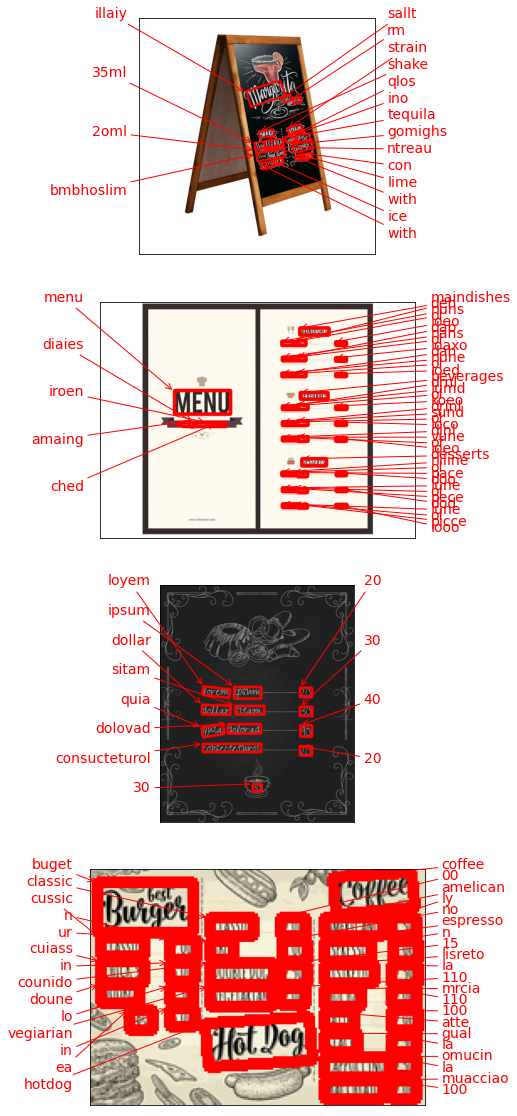

In [10]:
# Plot the predictions
fig, axs = plt.subplots(nrows=len(images), figsize=(20, 20))
for idx, ax in enumerate(axs):
    keras_ocr.tools.drawAnnotations(image=images[idx], 
                                    predictions=prediction_groups[idx][0], ax=ax)

### 3. Tesseract

In [11]:
# OCR Engine modes(–oem):
# 0 - Legacy engine only.
# 1 - Neural nets LSTM engine only.
# 2 - Legacy + LSTM engines.
# 3 - Default, based on what is available.

# Page segmentation modes(–psm):
# 0 - Orientation and script detection (OSD) only.
# 1 - Automatic page segmentation with OSD.
# 2 - Automatic page segmentation, but no OSD, or OCR.
# 3 - Fully automatic page segmentation, but no OSD. (Default)
# 4 - Assume a single column of text of variable sizes.
# 5 - Assume a single uniform block of vertically aligned text.
# 6 - Assume a single uniform block of text.
# 7 - Treat the image as a single text line.
# 8 - Treat the image as a single word.
# 9 - Treat the image as a single word in a circle.
# 10 - Treat the image as a single character.
# 11 - Sparse text. Find as much text as possible in no particular order.
# 12 - Sparse text with OSD.
# 13 - Raw line. Treat the image as a single text line, bypassing hacks that are Tesseract-specific.

def crop_word_regions(image_path='./images/sample.png', output_path='./output'):
    if not os.path.exists(output_path):
        os.mkdir(output_path)
    custom_oem_psm_config = r'--oem 3 --psm 3'
    image = Image.open(image_path)

    recognized_data = pytesseract.image_to_data(
        image, lang='eng',    # 영어라면 lang='eng', 한국어라면 lang='kor'
        config=custom_oem_psm_config,
        output_type=Output.DICT
    )
    
    top_level = max(recognized_data['level'])
    index = 0
    cropped_image_path_list = []
    for i in range(len(recognized_data['level'])):
        level = recognized_data['level'][i]
    
        if level == top_level:
            left = recognized_data['left'][i]
            top = recognized_data['top'][i]
            width = recognized_data['width'][i]
            height = recognized_data['height'][i]
            
            output_img_path = os.path.join(output_path, f"{str(index).zfill(4)}.png")
            print(output_img_path)
            cropped_image = image.crop((
                left,
                top,
                left+width,
                top+height
            ))
            cropped_image.save(output_img_path)
            cropped_image_path_list.append(output_img_path)
            index += 1
    return cropped_image_path_list

In [12]:
work_dir = os.getenv('HOME')+'/aiffel/ocr_python/image'
img_file_path = work_dir + '/menu4.jpg'   #테스트용 이미지 경로입니다. 본인이 선택한 파일명으로 바꿔주세요. 

In [13]:
cropped_image_path_list = crop_word_regions(img_file_path, work_dir)

/aiffel/aiffel/ocr_python/image/0000.png
/aiffel/aiffel/ocr_python/image/0001.png
/aiffel/aiffel/ocr_python/image/0002.png
/aiffel/aiffel/ocr_python/image/0003.png
/aiffel/aiffel/ocr_python/image/0004.png
/aiffel/aiffel/ocr_python/image/0005.png
/aiffel/aiffel/ocr_python/image/0006.png
/aiffel/aiffel/ocr_python/image/0007.png
/aiffel/aiffel/ocr_python/image/0008.png
/aiffel/aiffel/ocr_python/image/0009.png
/aiffel/aiffel/ocr_python/image/0010.png
/aiffel/aiffel/ocr_python/image/0011.png
/aiffel/aiffel/ocr_python/image/0012.png
/aiffel/aiffel/ocr_python/image/0013.png
/aiffel/aiffel/ocr_python/image/0014.png
/aiffel/aiffel/ocr_python/image/0015.png
/aiffel/aiffel/ocr_python/image/0016.png
/aiffel/aiffel/ocr_python/image/0017.png
/aiffel/aiffel/ocr_python/image/0018.png
/aiffel/aiffel/ocr_python/image/0019.png
/aiffel/aiffel/ocr_python/image/0020.png
/aiffel/aiffel/ocr_python/image/0021.png
/aiffel/aiffel/ocr_python/image/0022.png


In [14]:
def recognize_images(cropped_image_path_list):
    custom_oem_psm_config = r'--oem 3 --psm 7'
    
    for image_path in cropped_image_path_list:
        image = Image.open(image_path)
        recognized_data = pytesseract.image_to_string(
            image, lang='eng',    # 한국어라면 lang='kor'
            config=custom_oem_psm_config,
            output_type=Output.DICT
        )
        print(recognized_data['text'])
    print("Done")

In [15]:
# 위에서 준비한 문자 영역 파일들을 인식하여 얻어진 텍스트를 출력합니다.
recognize_images(cropped_image_path_list)

Busser

yi

U0

ee

LLANIL

iW)

Sas

op

0

:

WEG

0

is

| i)

VELELATIAN §=2

‘lt ie

Hol

vet 6

Oy ttl ie


=, 40

Malt TL ALD

/ WU

Done


## Step 3. 테스트 결과 정리

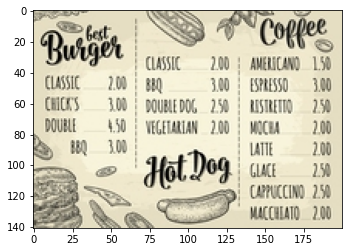

In [16]:
# 테스트용 이미지 확인
test_image_path = os.getenv('HOME')+'/aiffel/ocr_python/image/menu4.jpg'
img_bgr = cv2.imread(test_image_path)    #- OpenCV로 이미지를 읽기
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB) # opencv는 BGR를 사용하기에 RGB 이미지로 바꾸기
plt.imshow(img_rgb)
plt.show()

- 위 이미지를 비교용 이미지로 지정한 이유는 적당한 텍스트 양과 필기체가 있어서 선정했다.
- 중점적으로 확인할 부분은 Best Burger, Hot Dog, Coffee이다.

1. Google OCR API

In [17]:
detect_text(test_image_path)

Texts:

"Burger
best
Coffee
CLASSIC
2.00 AMERICANO 150
CLASSIC
CHICK'S
2.00 B80
3.00
ESPRESSO 3.00
3.00 DOUBLE DOG 250 RISTRETTO 250
2.00
2.00
DOUBLE
4.50 VEGETARIAN 2.00
關 100
MOCHA
LATTE
Hot Dog auE
GLACE
250
CAPPUCCINO 2.50
MACCHLATO 2.00
"

"Burger"

"best"

"Coffee"

"CLASSIC"

"2.00"

"AMERICANO"

"150"

"CLASSIC"

"CHICK'S"

"2.00"

"B80"

"3.00"

"ESPRESSO"

"3.00"

"3.00"

"DOUBLE"

"DOG"

"250"

"RISTRETTO"

"250"

"2.00"

"2.00"

"DOUBLE"

"4.50"

"VEGETARIAN"

"2.00"

"關"

"100"

"MOCHA"

"LATTE"

"Hot"

"Dog"

"auE"

"GLACE"

"250"

"CAPPUCCINO"

"2.50"

"MACCHLATO"

"2.00"
bounds: (181,127),(192,127),(192,135),(181,135)


- Best Burger, Hot Dog, Coffee가 인식되었고 전반적인 인식률이 잘 된 것 같다.
- 중간에 한자는 왜 나온건 지 모르겠다.
- 출력되는 순서를 보면 좌상단부터 오른쪽방향으로 위에서 아래로 인식하여 메뉴판 방향과는 다르게 인식된 것을 볼 수 있다.

2.  keras-ocr

![menu.jpg](/EXPLORATION_18/ex_keras.png)

- Burger, Hot Dog, Coffee가 인식되었고 best Burger에서 best 부분은 인식하지 못했다.
- 각 위치 별로 문자와 배경이 잘 나뉘어 졌다.
- 숫자도 그렇고 정확하지 않은 부분들이 있다.

3. Tesseract

In [18]:
# 위에서 준비한 문자 영역 파일들을 인식하여 얻어진 텍스트를 출력합니다.
recognize_images(cropped_image_path_list)

Busser

yi

U0

ee

LLANIL

iW)

Sas

op

0

:

WEG

0

is

| i)

VELELATIAN §=2

‘lt ie

Hol

vet 6

Oy ttl ie


=, 40

Malt TL ALD

/ WU

Done


- Best Burger, Hot Dog, Coffee 모두 인식하지 못하였다.
- 새로운 모델을 만드는 게 더 좋은 결과를 내지 않을까 싶다.

## Step 4. 결과 분석과 결론 제시

- Google OCR API, keras-ocr, Tesseract 세가지를 비교해 봤을 때 **Google OCR API**가 가장 좋은 인식률을 보였다.
- 다만 keras-ocr가 글씨가 어디에 표시되어 있는지 표기를 해주는 점을 비교해본다면 해당 기능을 활용하면 좋을 것 같다.
- Tesseract는 손글씨가 인식이 잘 안되는 것 같아 타이핑된 메뉴판도 시도해봤으나 디텍션 조차 제대로 하지 못했다.
- Tesseract의 인식률 향상을 시도하는 것보다 다른 API를 사용하는게 더 효과적일 것 같다.

---

## 루브릭 관련 고려한 점

**1. OCR을 활용하여 구현하려는 서비스의 기획이 타당한가?**

- 목표로 하는 서비스가 OCR를 적용 가능하며, OCR을 활용했을 때 더욱 유용해진다.

**2. 모델 평가기준이 명확하고 체계적으로 세워졌는가?**

- 평가 기준에 부합하는 테스트 데이터의 특징이 무엇인지 명확하게 제시되었다.

**3. 평가기준에 따라 충분한 분량의 테스트가 진행되고 그 결과가 잘 정리되었는가?**

- 최대 20장까지의 테스트 이미지를 사용해 제시된 평가 기준에 따른 테스트 결과가 잘 정리되어 결론이 도출되었다.

## 회고
1️⃣ 잘한 점:

- 배우는 것들이 점점 많아지고 해야할 것들이 많은데 포기하지 않고 하고 있는게 잘한게 아닐까 싶다.
- 뛰어난 점은 잘 모르겠고 잘한 점은 각 API를 성공적으로 불러온 거 정도인 것 같다.

2️⃣ 어려웠던 점:

- Tesseract가 자꾸 오류가 발생해서 패키지 재설치도 하고 lms도 여러번 재시작을 해봤다.
- Tesseract가 구글이나 케라스보다 상대적으로 인식률이 낮은 것 같다.
- 한글이라 인식을 잘 못하는 것 같다.

3️⃣ 느낀 점:

- 결과적으로 봤을 때 Google OCR API가 가장 성능이 우수했는데, 유료의 힘인가 생각했다.